# Оптимизация производственных расходов

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Шаги исследования

1. Загрузка данных
2. Исследовательский анализ данных
3. Предобработка данных
4. Подготовка признаков к обучению
5. Обучение нескольких моделей
6. Проверка наилучшей модели на тестовой выборке
7. Анализ важности факторов
8. Отчет по проекту

## Загрузка данных

In [1]:
pip install shap

     |████████████████████████████████| 572 kB 1.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Импорт нужных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
import shap 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Введем константы
RANDOM_STATE = 220523
TEST_SIZE = 0.25
CV = 8

In [4]:
try:
    data_arc = pd.read_csv(r"C:\Users\stasf\Desktop\data_arc_new.csv") # данные об электродах
    data_bulk = pd.read_csv(r"C:\Users\stasf\Desktop\data_bulk_new.csv") # данные о подаче сыпучих материалов (объем)
    data_bulk_time = pd.read_csv(r"C:\Users\stasf\Desktop\data_bulk_time_new.csv") # данные о подаче сыпучих материалов (время)
    data_gas = pd.read_csv(r"C:\Users\stasf\Desktop\data_gas_new.csv") # данные о продувке сплава газом
    data_temp = pd.read_csv(r"C:\Users\stasf\Desktop\data_temp_new.csv") # результаты измерения температуры
    data_wire = pd.read_csv(r"C:\Users\stasf\Desktop\data_wire_new.csv") # данные о проволочных материалах (объём)
    data_wire_time= pd.read_csv(r"C:\Users\stasf\Desktop\data_wire_time_new.csv") # данные о проволочных материалах (время)
except FileNotFoundError:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

## 1.Исследовательский анализ данных

In [5]:
# Функция описания данных
def data_info(data):
    print("Количество строк:", data.shape[0])
    print("Количество столбцов:", data.shape[1])
    display(data.head(5))
    data.info()
    display(data.describe())

### Данные об электродах

In [6]:
print("Данные об электродах")
data_info(data_arc)

Данные об электродах
Количество строк: 14876
Количество столбцов: 5


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [7]:
# Найдем строчки с отрицательными значениями реактивной мощности
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Данная итерация - выброс. Удалим из датафрейма всю партию с ключом `2116` и построим графики распредления и "ящик с усами" для новго датафрейма.

In [8]:
# Датафрейм без итерации 2116
data_arc_2 = data_arc[data_arc['key'] != 2116]

<Figure size 432x288 with 0 Axes>

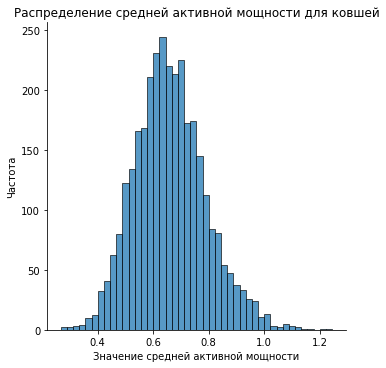

In [9]:
plt.figure()
sns.displot(data_arc.groupby('key')['Активная мощность'].mean())
plt.title('Распределение средней активной мощности для ковшей')
plt.xlabel('Значение средней активной мощности')
plt.ylabel('Частота')
plt.show()

Text(0.5, 1.0, 'Боксплот для средней активной мощности')

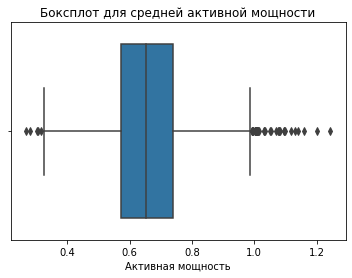

In [10]:
sns.boxplot(data_arc.groupby('key')['Активная мощность'].mean())
plt.title('Боксплот для средней активной мощности')
plt.show()

<Figure size 432x288 with 0 Axes>

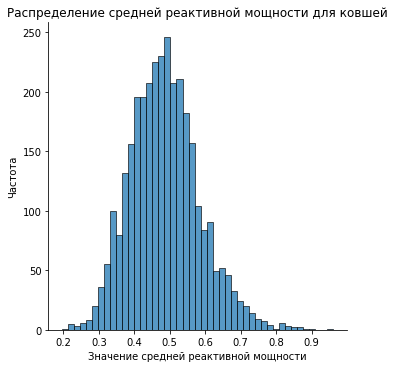

In [11]:
plt.figure()
sns.displot(data_arc_2.groupby('key')['Реактивная мощность'].mean())
plt.title('Распределение средней реактивной мощности для ковшей')
plt.xlabel('Значение средней реактивной мощности')
plt.ylabel('Частота')
plt.show()

Text(0.5, 1.0, 'Боксплот для средней реактивной мощности')

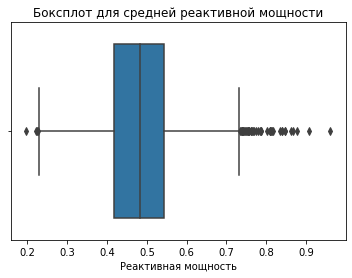

In [12]:
sns.boxplot(data_arc_2.groupby('key')['Реактивная мощность'].mean())
plt.title('Боксплот для средней реактивной мощности')
plt.show()

Text(3.799999999999997, 0.5, 'Частота')

<Figure size 432x288 with 0 Axes>

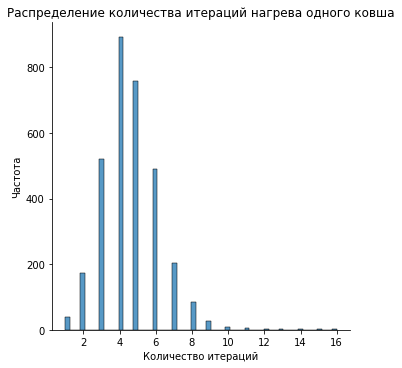

In [13]:
plt.figure()
sns.displot(data_arc.groupby('key')['Активная мощность'].count())
plt.title('Распределение количества итераций нагрева одного ковша')
plt.xlabel('Количество итераций')
plt.ylabel('Частота')
plt.show()

**Вывод:**
1. В данных отсутствуют пропуски.
2. `Средняя активная мощность` для ковша имеет нормальное распредление.
3. На графике "ящик с усами" для `средней активной мощности` наблюдаются выбросы.
4. `Средняя реактивная мощность` имеет отрицательное минимальтное значение - `-715.479924`. Очевидно, что это похоже на выброс, от которого нужно будет избавиться в дальнейшем в процессе предобработки данных.
5. Удалили итерацию с ключом `2116` (содержащую выброс) и построили графики распределения и "ящик с усами".
6. `Средняя реактивная мощность` для ковша имеет нормальное распредление.
7. На графике "ящик с усами" для `средней реактивной мощности` наблюдаются выбросы.
8. График количества итераций нагрева имеет нормальное распределение. Чаще всего ковш проходит **4 итерации**.

### Данные о подаче сыпучих материалов (объем)

In [14]:
print("Данные о подаче сыпучих материалов (объем)")
data_info(data_bulk)

Данные о подаче сыпучих материалов (объем)
Количество строк: 3129
Количество столбцов: 16


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Text(0, 0.5, 'Частота')

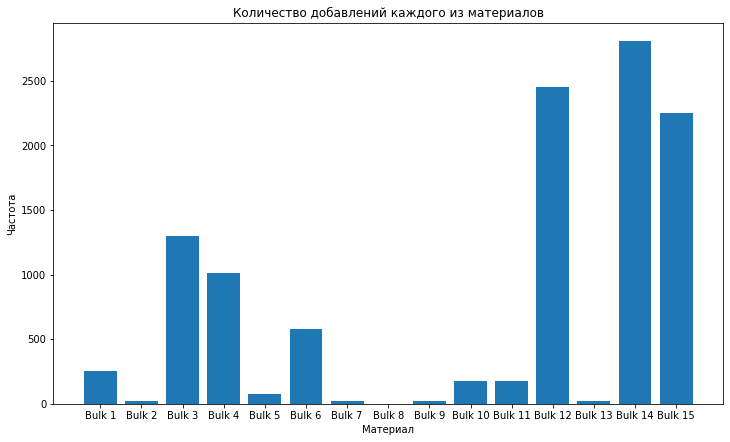

In [15]:
plt.figure(figsize=(12, 7))
plt.bar(data_bulk.drop('key', axis=1).columns, data_bulk.drop('key', axis=1).count())
plt.title('Количество добавлений каждого из материалов')
plt.xlabel('Материал')
plt.ylabel('Частота')
plt.show()

**Вывод:**
1. В датафрейме содержится множество пропусков. Вероятнее всего, эти пропуски означают что сыпучий материал не добавлялся в данный ковш.
2. Посмотрели, какие материалы чаще всего использовались для добавки: это номера `14`, `12`, `15`, `3`, `4`.

### Данные о подаче сыпучих материалов (время)

In [16]:
print("Данные о подаче сыпучих материалов (время)")
data_info(data_bulk_time)

Данные о подаче сыпучих материалов (время)
Количество строк: 3129
Количество столбцов: 16


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Данные этого датафрейма сопоставимы с датафреймом `Данные о подаче сыпучих материалов (объем)`. Для каждого добавления здесь указаны дата и время.

### Данные о продувке сплава газом

In [17]:
print("Данные о продувке сплава газом")
data_info(data_gas)

Данные о продувке сплава газом
Количество строк: 3239
Количество столбцов: 2


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<Figure size 432x288 with 0 Axes>

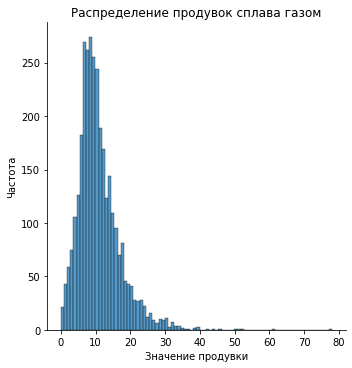

In [18]:
plt.figure()
sns.displot(data_gas['Газ 1'])
plt.title('Распределение продувок сплава газом')
plt.xlabel('Значение продувки')
plt.ylabel('Частота')
plt.show()

Text(0.5, 0, 'Показатель газа')

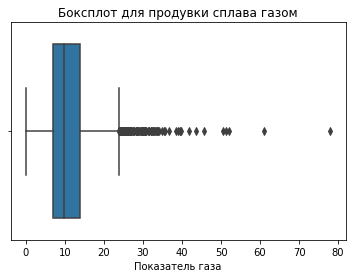

In [19]:
sns.boxplot(data_gas['Газ 1'])
plt.title('Боксплот для продувки сплава газом')
plt.xlabel('Показатель газа')
plt.show()

**Вывод:**
1. В данных отсуствуют пропуски.
2. Изучили описательные статистики: нет ничего необычного.
3. Построили гистограмму частот - распределение нормальное.
4. По графику "ящик с усами" видны выбросы.

### Результаты измерения температуры

In [20]:
print("Результаты измерения температуры")
data_info(data_temp)

Результаты измерения температуры
Количество строк: 18092
Количество столбцов: 3


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


<Figure size 432x288 with 0 Axes>

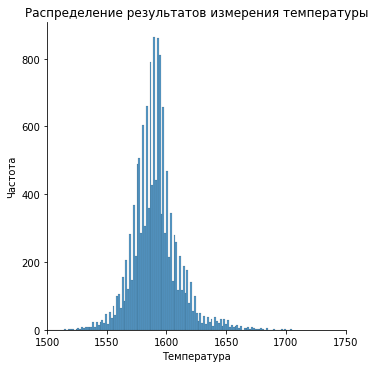

In [21]:
plt.figure()
sns.displot(data_temp['Температура'])
plt.title('Распределение результатов измерения температуры')
plt.xlabel('Температура')
plt.ylabel('Частота')
plt.xlim([1500, 1750])
plt.show()

Text(0.5, 1.0, 'Боксплот для показателей температуры')

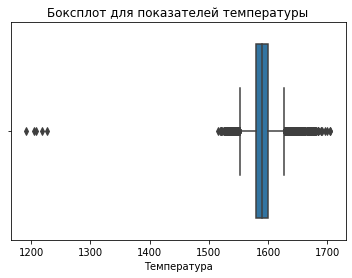

In [22]:
sns.boxplot(data_temp['Температура'])
plt.title('Боксплот для показателей температуры')
plt.show()

**Вывод:**
1. В данных присутствуют пропуски.
2. Показатели температуры распредлены нормально.
3. На графике "ящик с усами" видны выбросы.

### Данные о проволочных материалах (объём)

In [23]:
print("Данные о проволочных материалах (объём)")
data_info(data_wire)

Данные о проволочных материалах (объём)
Количество строк: 3081
Количество столбцов: 10


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Text(0, 0.5, 'Частота')

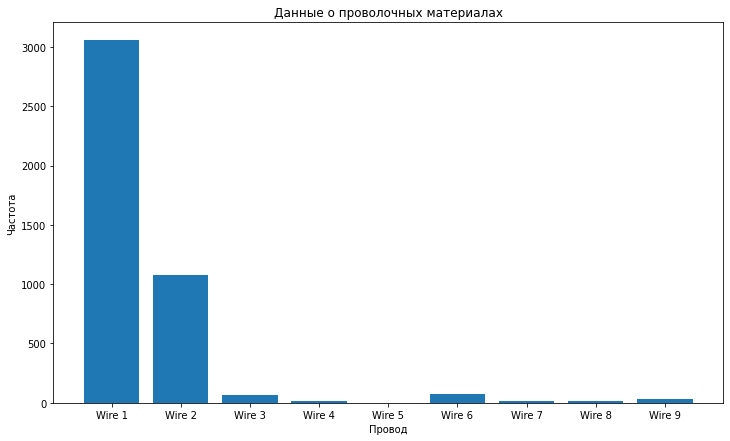

In [24]:
plt.figure(figsize=(12, 7))
plt.bar(data_wire.drop('key', axis=1).columns, data_wire.drop('key', axis=1).count())
plt.title('Данные о проволочных материалах')
plt.xlabel('Провод')
plt.ylabel('Частота')
plt.show()

**Вывод:**
1. В датафрейме множество пропусков. Вероятно, это говорит об отсутствии добавки проволочного материала.
2. Самые популярные проволочные материалы по номерами `1`, `2`, `6`, `3`.

### Данные о проволочных материалах (время)

In [25]:
print("Данные о проволочных материалах (время)")
data_info(data_wire_time)

Данные о проволочных материалах (время)
Количество строк: 3081
Количество столбцов: 10


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Данные этого датафрейма сопоставимы с датафреймом `Данные о проволочных материалах`. Для каждого добавления здесь указаны дата и время.

**Общий вывод:**
1. Были выгружены все данные.
2. Было проведено исследование каждого датафрейма - их вывод, описательные статистики, визуализация данных и информация о них.
3. В датафреймах `data_bulk` и `data_wire` присутствует огромное количество пропусков. Они означают, что сыпучие и проволочные материалы в данную партию не добавлялись. В ходе предобработки данных заполним эти пропуски значение `0`.
4. Датафреймы `data_bulk_time` и `data_wire_time` сопоставимы с `data_bulk` и `data_wire`. Их мы использовать далее не будем.
5. В датафрейме `data_arc` и `data_time` содержатся выбросы. В ходе предобработки их придется удалить.

## 3. Предобработка данных

### Данные об электродах 

Узнаем общее время нагрева дугой.

In [26]:
data_arc_2['Начало нагрева дугой'] = pd.to_datetime(data_arc_2['Начало нагрева дугой'])
data_arc_2['Конец нагрева дугой'] = pd.to_datetime(data_arc_2['Конец нагрева дугой'])
data_arc_2['Время нагрева дугой'] = (data_arc_2['Конец нагрева дугой'] - data_arc_2['Начало нагрева дугой']).dt.total_seconds()

In [27]:
data_arc_2 = data_arc_2.groupby('key')['Активная мощность', 'Реактивная мощность', 'Время нагрева дугой'].sum()
data_arc_2['Полная мощность'] = (data_arc_2['Активная мощность'])**2 + (data_arc_2['Реактивная мощность'])**2
data_arc_2

,Активная мощность,Реактивная мощность,Время нагрева дугой,Полная мощность
key,,,,
1,3.036730,2.142821,1098.0,13.813411
2,2.139408,1.453357,811.0,6.689313
3,4.063641,2.937457,655.0,25.141832
4,2.706489,2.056992,741.0,11.556299
5,2.252950,1.687991,869.0,7.925097
...,...,...,...,...
3237,2.541872,2.025417,909.0,10.563427
3238,1.374821,1.038103,546.0,2.967791
3239,4.848005,3.541541,1216.0,36.045665


Агрегировали и суммировали мощности. Добавили новый столбец - `Полная мощность`. Он вычисляется как сумма квадратов `Активной мощности` и `Реактивной мощности`.

### Данные о подаче сыпучих материалов (объем)

In [28]:
data_bulk = data_bulk.fillna(0)
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


Заполнили пропуски нулевыми значениями, перезаписав датафрейм.

### Результаты измерения температуры

In [29]:
data_temp[data_temp['Температура'] < 1400]

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


Обнаружили номера партий, в которых были зафиксированы статистические выбросы в замере температуры. Их ключ - `867`, `1214`, `1619`, `2052`, `2561`. Удалим из датафрейма все эти партии.

In [30]:
values = data_temp[data_temp['Температура'] < 1400]['key'].unique().tolist() # Список ключей, которые нужно удалить из data_temp
data_temp = data_temp.query('key not in @values')
data_temp[data_temp['Температура'] < 1400]

,key,Время замера,Температура


In [31]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18065 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18065 non-null  int64  
 1   Время замера  18065 non-null  object 
 2   Температура   14643 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 564.5+ KB


Также определим партии, где есть пропуски в столбце `Температура`.

In [32]:
data_temp.isnull().sum()

key                0
Время замера       0
Температура     3422
dtype: int64

In [33]:
# Номера партий, в которых есть пропуски
unique_nan_keys = data_temp[data_temp['Температура'].isna()]['key'].unique().tolist()

In [34]:
data_temp = data_temp.query('key not in @unique_nan_keys')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13905 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           13905 non-null  int64  
 1   Время замера  13905 non-null  object 
 2   Температура   13905 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 434.5+ KB


In [35]:
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


Удалили все партии, содержащие хоть один пропуск в замере температуры.

###  Данные о проволочных материалах (объём)

In [36]:
data_wire = data_wire.fillna(0)
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Заполнили пропуск нулевыми значениями, перезаписав датафрейм.

## 4. Объединение датафреймов

In [37]:
data = data_arc_2.merge(data_bulk, on='key', how='inner').merge(data_gas, on='key', how='inner').merge(data_wire, on='key', how='inner')

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3021 entries, 0 to 3020
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  3021 non-null   int64  
 1   Активная мощность    3021 non-null   float64
 2   Реактивная мощность  3021 non-null   float64
 3   Время нагрева дугой  3021 non-null   float64
 4   Полная мощность      3021 non-null   float64
 5   Bulk 1               3021 non-null   float64
 6   Bulk 2               3021 non-null   float64
 7   Bulk 3               3021 non-null   float64
 8   Bulk 4               3021 non-null   float64
 9   Bulk 5               3021 non-null   float64
 10  Bulk 6               3021 non-null   float64
 11  Bulk 7               3021 non-null   float64
 12  Bulk 8               3021 non-null   float64
 13  Bulk 9               3021 non-null   float64
 14  Bulk 10              3021 non-null   float64
 15  Bulk 11              3021 non-null   f

In [39]:
data_target = data_temp.groupby(by='key', as_index = False).agg(['first', 'last'])

In [40]:
data_target

Время замера                      Температура        
                    first                 last       first    last
key                                                               
1     2019-05-03 11:02:04  2019-05-03 11:30:38      1571.0  1613.0
2     2019-05-03 11:34:04  2019-05-03 11:55:09      1581.0  1602.0
3     2019-05-03 12:06:44  2019-05-03 12:35:57      1596.0  1599.0
4     2019-05-03 12:39:27  2019-05-03 12:59:47      1601.0  1625.0
5     2019-05-03 13:11:03  2019-05-03 13:36:39      1576.0  1602.0
...                   ...                  ...         ...     ...
2495  2019-08-10 11:27:47  2019-08-10 11:50:47      1570.0  1591.0
2496  2019-08-10 11:56:48  2019-08-10 12:25:13      1554.0  1591.0
2497  2019-08-10 12:37:26  2019-08-10 12:53:28      1571.0  1589.0
2498  2019-08-10 12:58:11  2019-08-10 13:23:31      1591.0  1594.0
2499  2019-08-10 13:33:21  2019-08-10 13:58:58      1569.0  1603.0

[2473 rows x 4 columns]

In [41]:
data_target.columns = ['time_first', 'time_last', 'first_temp', 'last_temp']

In [42]:
data_target

,time_first,time_last,first_temp,last_temp
key,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0
...,...,...,...,...
2495,2019-08-10 11:27:47,2019-08-10 11:50:47,1570.0,1591.0
2496,2019-08-10 11:56:48,2019-08-10 12:25:13,1554.0,1591.0
2497,2019-08-10 12:37:26,2019-08-10 12:53:28,1571.0,1589.0


Нашли первый и последний замер температур для каждой партии. Объединим `data_target` и `data`.

In [43]:
data = data.merge(data_target, on='key', how='inner')
data['time_first'] = pd.to_datetime(data['time_first'])
data['time_last'] = pd.to_datetime(data['time_last'])
data['Время замера'] = (data['time_last'] - data['time_first']).dt.total_seconds()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   key                  2324 non-null   int64         
 1   Активная мощность    2324 non-null   float64       
 2   Реактивная мощность  2324 non-null   float64       
 3   Время нагрева дугой  2324 non-null   float64       
 4   Полная мощность      2324 non-null   float64       
 5   Bulk 1               2324 non-null   float64       
 6   Bulk 2               2324 non-null   float64       
 7   Bulk 3               2324 non-null   float64       
 8   Bulk 4               2324 non-null   float64       
 9   Bulk 5               2324 non-null   float64       
 10  Bulk 6               2324 non-null   float64       
 11  Bulk 7               2324 non-null   float64       
 12  Bulk 8               2324 non-null   float64       
 13  Bulk 9               2324 non-nul

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   key                  2324 non-null   int64         
 1   Активная мощность    2324 non-null   float64       
 2   Реактивная мощность  2324 non-null   float64       
 3   Время нагрева дугой  2324 non-null   float64       
 4   Полная мощность      2324 non-null   float64       
 5   Bulk 1               2324 non-null   float64       
 6   Bulk 2               2324 non-null   float64       
 7   Bulk 3               2324 non-null   float64       
 8   Bulk 4               2324 non-null   float64       
 9   Bulk 5               2324 non-null   float64       
 10  Bulk 6               2324 non-null   float64       
 11  Bulk 7               2324 non-null   float64       
 12  Bulk 8               2324 non-null   float64       
 13  Bulk 9               2324 non-nul

In [45]:
data = data.drop(['time_first', 'time_last'], axis=1)
data

,key,Активная мощность,Реактивная мощность,Время нагрева дугой,Полная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,first_temp,last_temp,Время замера
0,1,3.036730,2.142821,1098.0,13.813411,0.0,0.0,0.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,1613.0,1714.0
1,2,2.139408,1.453357,811.0,6.689313,0.0,0.0,0.0,73.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1581.0,1602.0,1265.0
2,3,4.063641,2.937457,655.0,25.141832,0.0,0.0,0.0,34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1596.0,1599.0,1753.0
3,4,2.706489,2.056992,741.0,11.556299,0.0,0.0,0.0,81.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1601.0,1625.0,1220.0
4,5,2.252950,1.687991,869.0,7.925097,0.0,0.0,0.0,78.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1576.0,1602.0,1536.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,2495,3.168133,2.210936,723.0,14.925305,0.0,0.0,21.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1570.0,1591.0,1380.0
2320,2496,4.174918,2.872031,940.0,25.678502,0.0,0.0,0.0,63.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1554.0,1591.0,1705.0
2321,2497,3.605239,2.452092,569.0,19.010503,0.0,0.0,0.0,85.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,1589.0,962.0
2322,2498,3.202310,2.239820,750.0,15.271583,0.0,0.0,90.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1591.0,1594.0,1520.0


<AxesSubplot:>

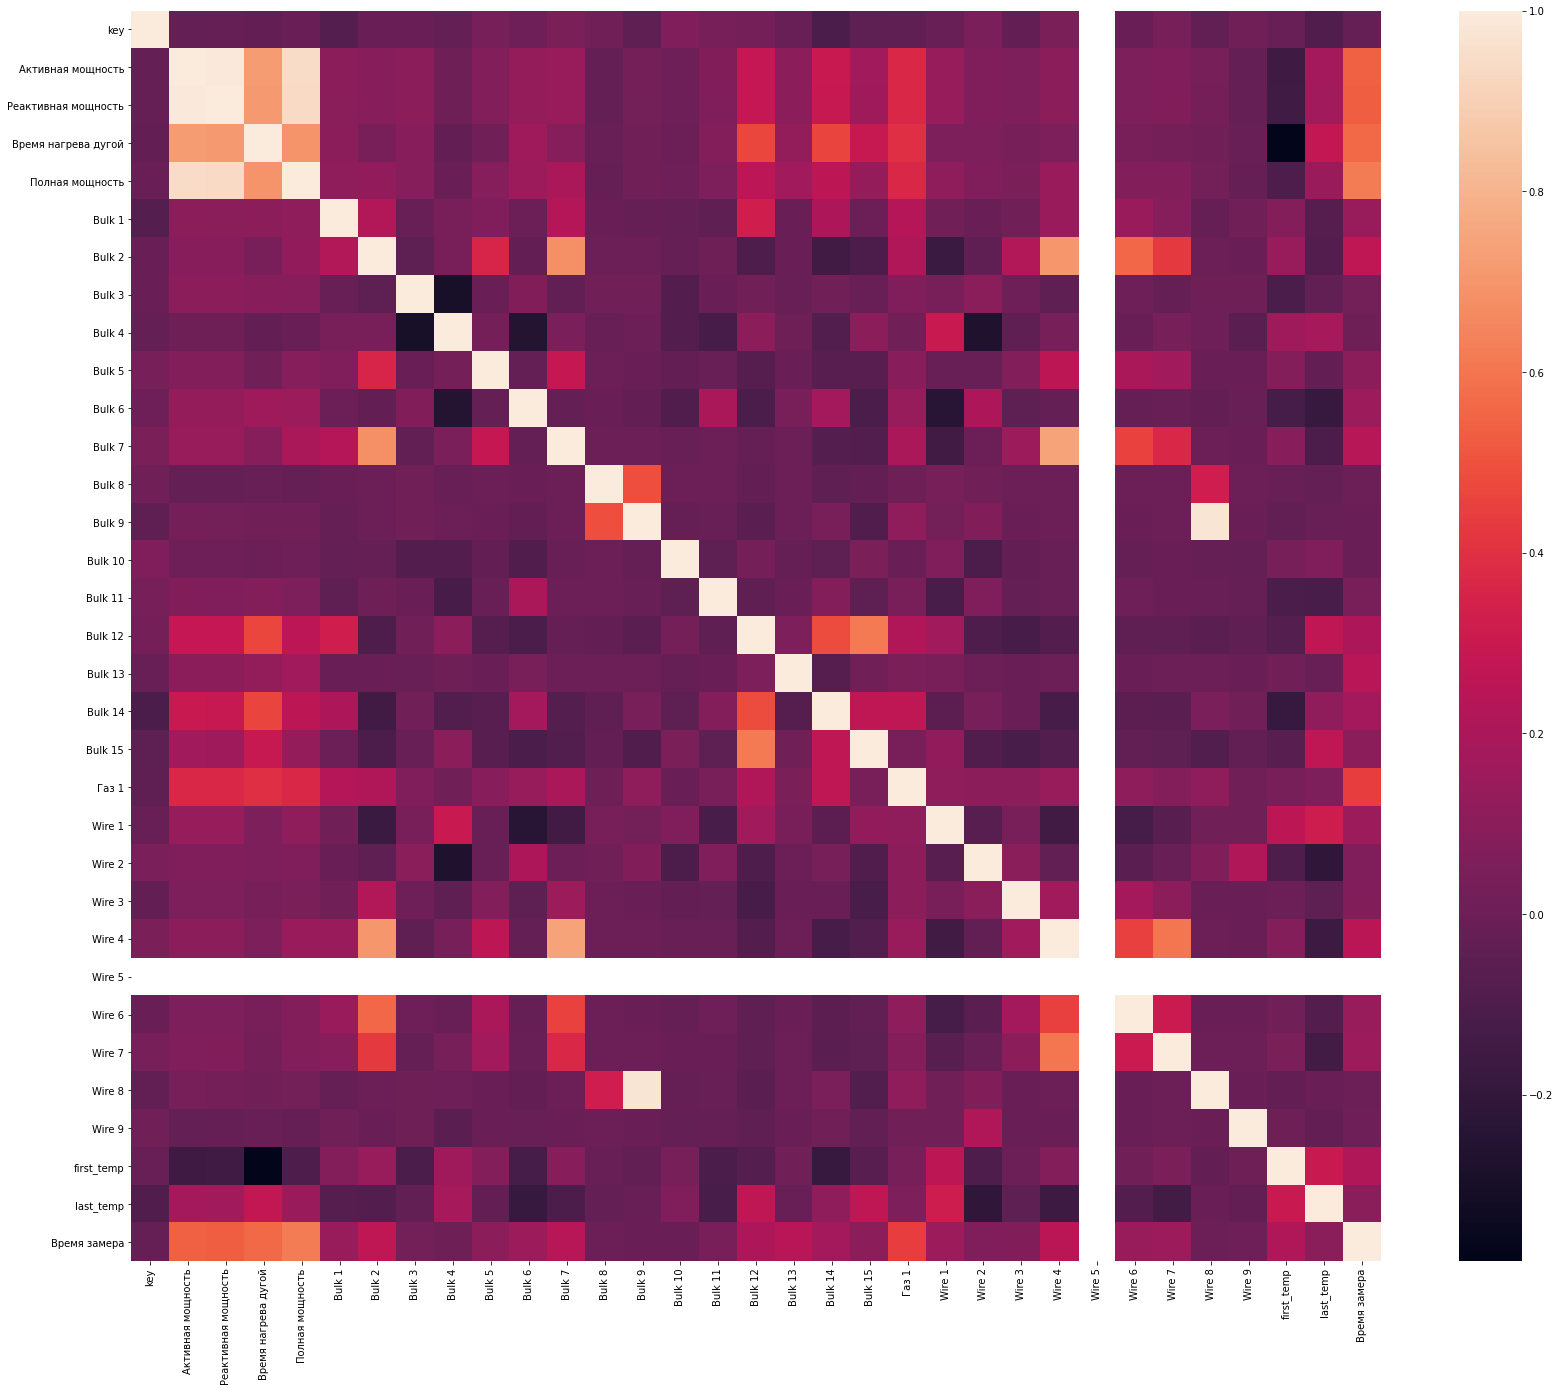

In [46]:
plt.figure(figsize=(28, 23))
sns.heatmap(data.corr())

Столбец `Wire 5` абсолютно нулевой. Его можно удалить.

In [47]:
data = data.drop('Wire 5', axis=1)

<AxesSubplot:>

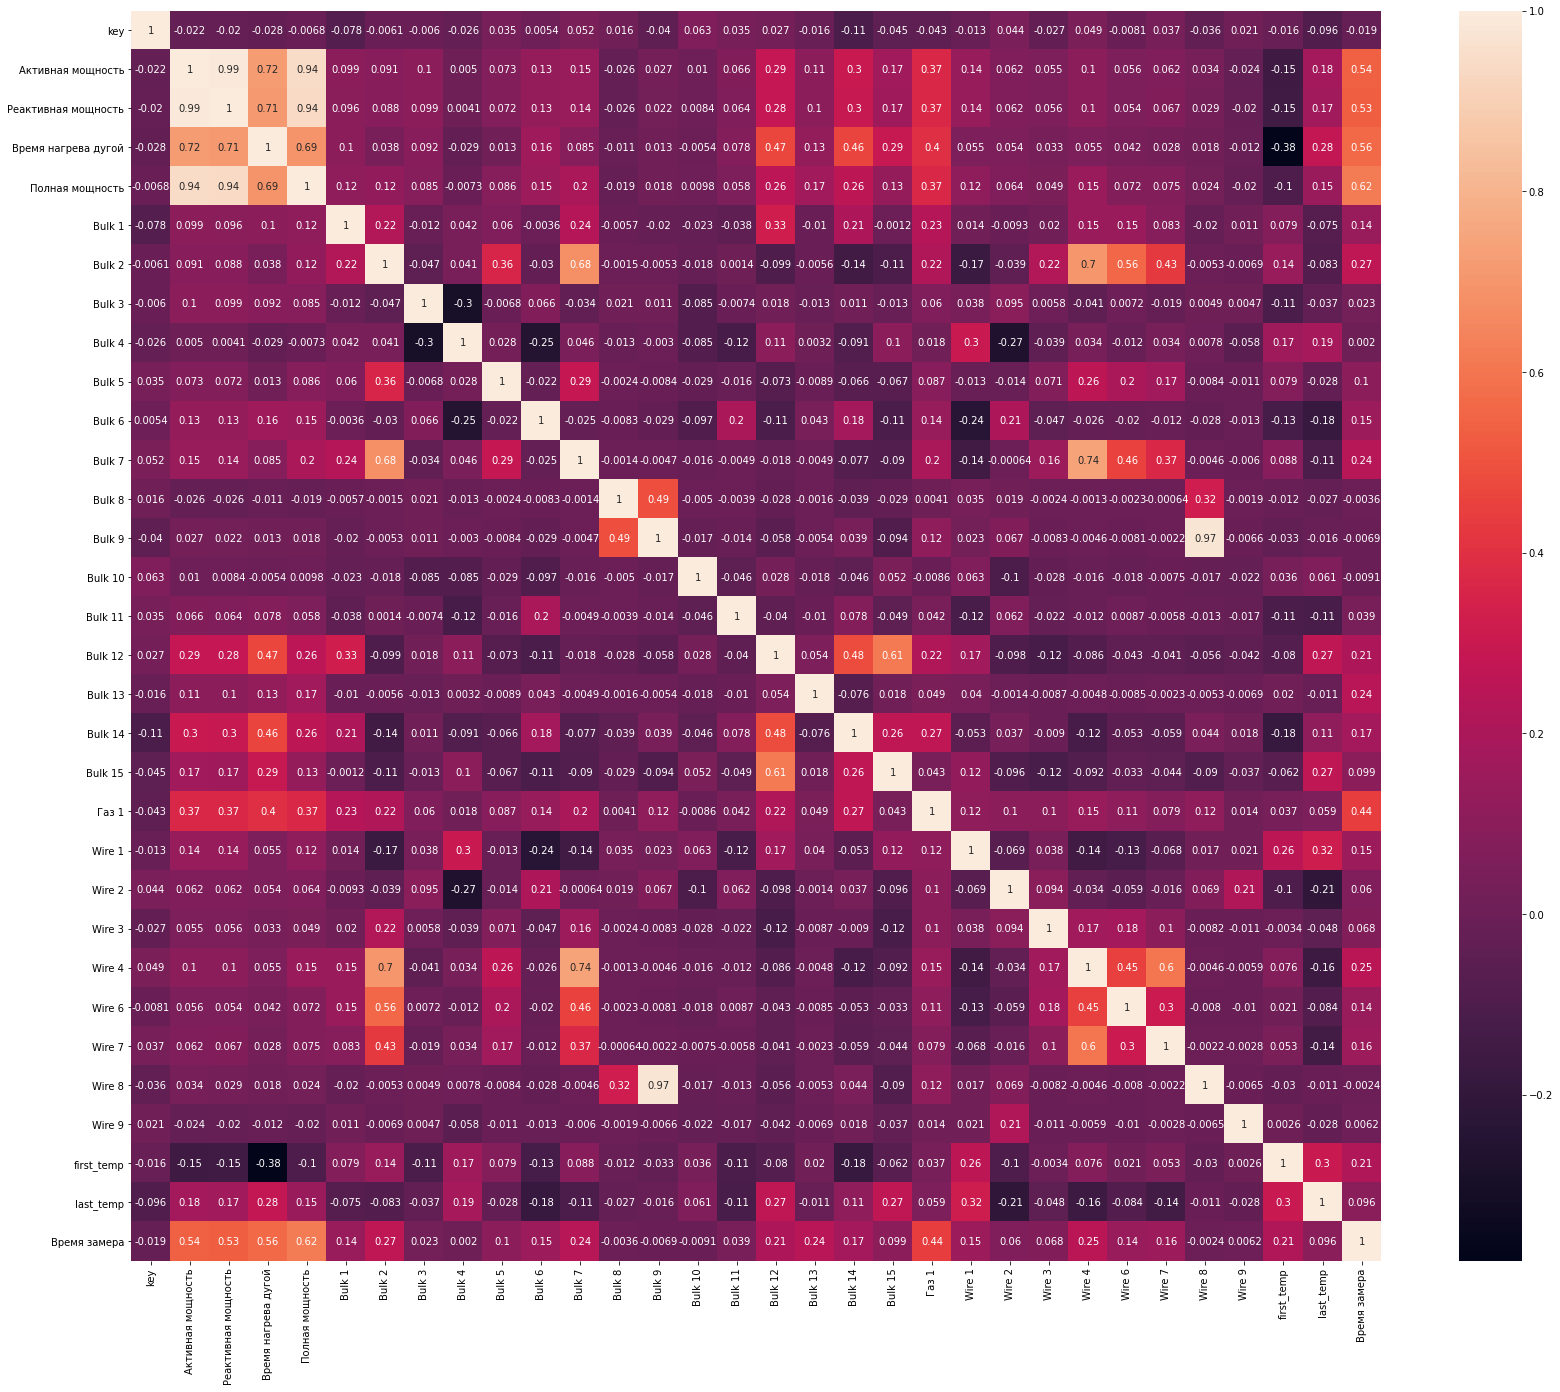

In [48]:
plt.figure(figsize=(28, 23))
sns.heatmap(data.corr(), annot=True)

По тепловой карте видна корреляция между `Активной мощностью`, `Реактивной мощностью` и `Полной мощностью`. Также обнаружилась корреляция между сыпучим материалом `Bulk 9` и проволочным материалом `Wire 8` - `0.97`. Вероятно, это как-то связано с химическим составом стали.

Удалим столбцы `Активная мощность`, `Реактивная мощность` и `Bulk 9`.

Столбец `key` удалим - он не является признаком.

In [49]:
data = data.drop(['Активная мощность', 'Реактивная мощность', 'Bulk 9', 'key'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Время нагрева дугой  2324 non-null   float64
 1   Полная мощность      2324 non-null   float64
 2   Bulk 1               2324 non-null   float64
 3   Bulk 2               2324 non-null   float64
 4   Bulk 3               2324 non-null   float64
 5   Bulk 4               2324 non-null   float64
 6   Bulk 5               2324 non-null   float64
 7   Bulk 6               2324 non-null   float64
 8   Bulk 7               2324 non-null   float64
 9   Bulk 8               2324 non-null   float64
 10  Bulk 10              2324 non-null   float64
 11  Bulk 11              2324 non-null   float64
 12  Bulk 12              2324 non-null   float64
 13  Bulk 13              2324 non-null   float64
 14  Bulk 14              2324 non-null   float64
 15  Bulk 15              2324 non-null   f

**Общий вывод**:
1. В датафреймах `data_bulk` и `data_wire` присутствовало огромное количество пропусков. Они означали, что сыпучие и проволочные материалы в данную партию не добавлялись. Заполнили эти пропуски значение `0`.
2. В датафрейме `data_arc` и `data_time` содержались выбросы. Они были удалены.

## 5. Обучение моделей

In [50]:
# Разделим выборку на обучающую и тестовую
train, test = train_test_split(data, random_state=RANDOM_STATE, test_size=TEST_SIZE) 

train_features = train.drop('last_temp', axis=1)
train_target = train['last_temp']
test_features = test.drop('last_temp', axis=1)
test_target = test['last_temp']

In [51]:
scaler = MinMaxScaler()

scaler.fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

Провели масштабирование признаков.

**Дерево решений**

In [52]:
param_grid = {'max_depth': range(2, 19)}

model_1 = DecisionTreeRegressor(random_state=RANDOM_STATE)
search_1 = GridSearchCV(model_1, param_grid, cv=CV, scoring='neg_mean_absolute_error')
search_1.fit(train_features, train_target)
print('Лучшее значение MAE для дерева решений: {} при значениях гиперпараметров: {}'.format(round(-search_1.best_score_, 3), search_1.best_params_))

Лучшее значение MAE для дерева решений: 7.26 при значениях гиперпараметров: {'max_depth': 5}


**Линейная регрессия**

In [53]:
model_3 = LinearRegression()
search_3 = cross_val_score(model_3, train_features, train_target, cv=CV, scoring='neg_mean_absolute_error')
model_3.fit(train_features, train_target)
print("Среднее значение метрики MAE на кросс-валидации для линейной регрессии:", round(-search_3.mean(), 3))

Среднее значение метрики MAE на кросс-валидации для линейной регрессии: 5.929


**CatBoost**

In [54]:
model_4 = CatBoostRegressor(verbose=False, random_state=RANDOM_STATE)
search_4 = (cross_val_score(model_4, train_features, train_target, cv=CV, scoring='neg_mean_absolute_error').max())
print('Лучшее значение MAE CatBoostRegressor:', round(-search_4, 3))

best_params = CatBoostRegressor(verbose=False, random_state=RANDOM_STATE).fit(train_features, train_target).get_all_params()

Лучшее значение MAE CatBoostRegressor: 5.494


In [55]:
index = ['Дерево решений', 'Линейная регрессия', 'CatBoost']

data_res = {'MAE на трейне': [round(-search_1.best_score_, 3),
                             round(-search_3.mean()),
                             round(-search_4, 3)]}
results = pd.DataFrame(data=data_res, index=index)
results

,MAE на трейне
Дерево решений,7.260
Линейная регрессия,6.000
CatBoost,5.494


**Лучшая модель** - `CatBoost`. Он прошел порог по метрике `MAE <= 6.8`. Проверим модель на тестовой выборке.

## 6. Проверка лучшей модели на тестовой выборке

In [56]:
model = CatBoostRegressor(verbose=False)
model.set_params(**best_params)
model.fit(train_features, train_target)
predictions = model.predict(test_features)
MAE = mean_absolute_error(predictions, test_target)
print('MAE на тестовой выборке для лучшей модели CatBoost:', round(MAE, 3))

MAE на тестовой выборке для лучшей модели CatBoost: 5.71


## 7. Анализ важности факторов

In [57]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train.drop('last_temp', axis=1))

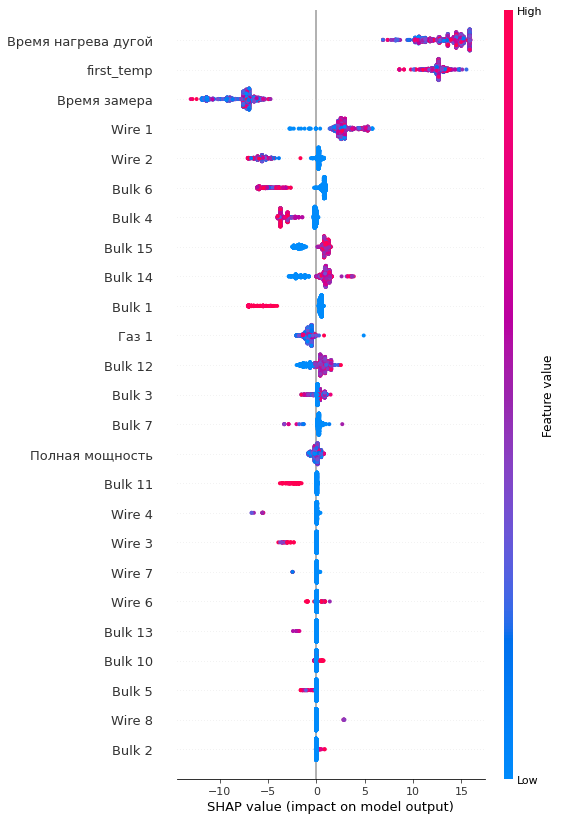

In [58]:
shap.summary_plot(shap_values, train.drop('last_temp', axis=1), max_display=25, auto_size_plot=True)

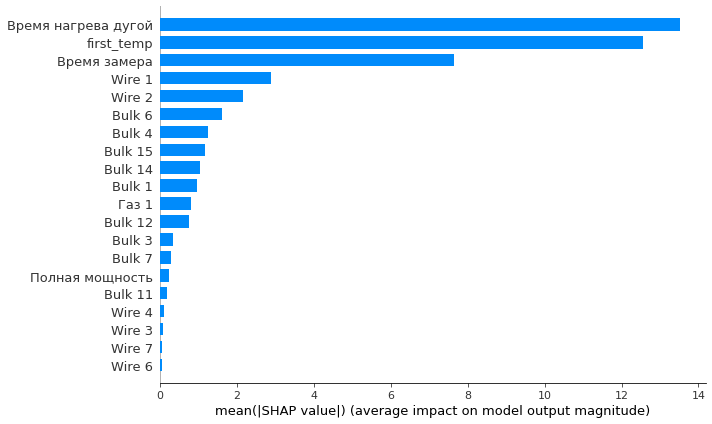

In [59]:
shap.summary_plot(shap_values, train.drop('last_temp', axis=1), plot_type="bar", plot_size=(10,6))

## Итог

1. Провели масштабирование признаков.
2. В ходе исследования было обучено три модели машинного обучения: `Дерево решений`, `Линейная регрессия` и `CatBoost`.
3. Лучшее значение метрики `MAE` на кросс-валидации удалось получить у `CatBoost` - `5.494`.
4. `MAE` на тестовой выборке у наилучшей модели - `5.71`.
5. Провели анализ важности признаков. Наибольшее значение имеют признаки `Время нагрева дугой`, `first_temp`, `Время замера`,  `Wire 1`, `Wire 2` и `Bulk 6`.

## Отчет

1. Все пункты планы были выполнены.
2. Возникли трудности сначала с пониманием самого производственного процесса. Но в ходе исследования мне удалось детально разобраться с процессами, это довольно интересно и познавательно.
3. Ключевые шаги - `Загрузка данных`, `Исследовтательский анализ данных`, `Предобработка данных`, `Обучение моделей`.
4. Итоговая модель - `CatBoostRegressor`. Метрика `MAE` на тестовой выборке равна `5.71`, что соответсвует ТЗ.

In [60]:
print('Список признаков: ')
data.info() 

Список признаков: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Время нагрева дугой  2324 non-null   float64
 1   Полная мощность      2324 non-null   float64
 2   Bulk 1               2324 non-null   float64
 3   Bulk 2               2324 non-null   float64
 4   Bulk 3               2324 non-null   float64
 5   Bulk 4               2324 non-null   float64
 6   Bulk 5               2324 non-null   float64
 7   Bulk 6               2324 non-null   float64
 8   Bulk 7               2324 non-null   float64
 9   Bulk 8               2324 non-null   float64
 10  Bulk 10              2324 non-null   float64
 11  Bulk 11              2324 non-null   float64
 12  Bulk 12              2324 non-null   float64
 13  Bulk 13              2324 non-null   float64
 14  Bulk 14              2324 non-null   float64
 15  Bulk 15            

1. `Данные об электродах`: а) Удалили партию с отрицательным показателем `Реактивной мощности`; б) вычислили полную мощность; в) вычислили время нагревания.
2. `Данные о подаче сыпучих материалов (объем)` - заполнили пропуски нулями.
3. `Данные о подаче сыпучих материалов (время)` - данные не использовались.
4. `Данные о продувке сплава газом` - предобработки данные не было, т.к. пропуски отсутствовали.
5. `Результаты измерения температуры` - а) Удалили партии с пропусками в `Температуре`; б) Вычислили время замера.
6. `Данные о проволочных материалах (объём)` - заполнили пропуски нулями.
7. `Данные о проволочных материалах (время)` - данные не использовались.